In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
import torch
import torch.utils
import torch.utils.data
from torch import nn

from tqdm import trange
import sys

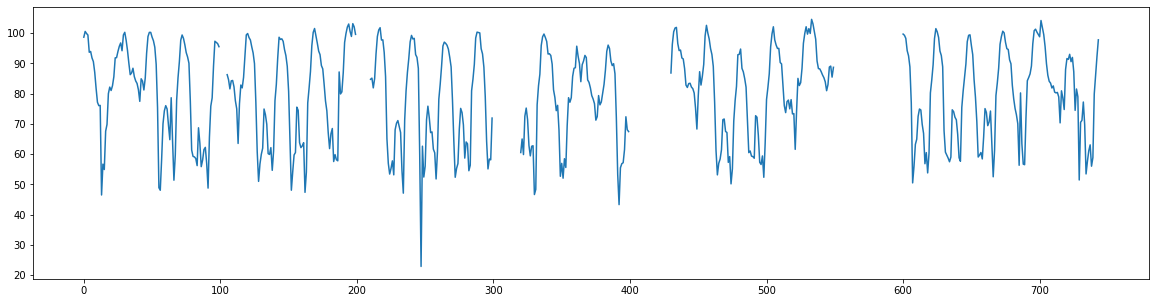

In [2]:
df = pd.read_csv("서인천IC-부평IC 평균속도.csv",encoding='CP949')
df2 = pd.DataFrame()
df2["time"] = pd.to_datetime(df["집계일시"],format="%Y%m%d%H%M")
df2["value"] = df["평균속도"]

missing_range = [(100,105),(200,210),(300,320),(400,430),(550,600)]
for start,end in missing_range:
    df2.iloc[start:end,1] = np.nan
plt.figure(figsize=(20,5))
plt.plot(df2["value"])
plt.show()

In [3]:
df2.to_csv("data.csv", index=False)

In [4]:
def makeBatch():
    df = pd.read_csv(path)
    min_max_scaler = MinMaxScaler()
    df = df[["time", "value"]]
    df["value"] = min_max_scaler.fit_transform(df["value"].values.reshape(-1,1))
    missing_list = df.isnull()["value"]
    data = df["value"].to_numpy()

    data_batch = []
    datas = []
    for index,val in enumerate(data):
        if missing_list[index]:
            datas=[]
            continue
        datas.append(val)         
        if len(datas)==window_size:
            data_batch.append(datas.copy())
            datas.pop(0)
    data_batch = np.array(data_batch)
    data_batch = data_batch.reshape(data_batch.shape[0], data_batch.shape[1], 1)
    return df,data, min_max_scaler, data_batch

In [5]:
class NAOMI(nn.Module):
    def __init__(self, params):
        super(NAOMI, self).__init__()

        self.params = params
        self.task = params['task']
        self.stochastic = (self.task == 'basketball')
        self.y_dim = params['y_dim']
        self.rnn_dim = params['rnn_dim']
        self.dims = {}
        self.n_layers = params['n_layers']
        self.networks = {}
        self.highest = params['highest']
        self.batch_size = params['batch']

        self.gru = nn.GRU(self.y_dim, self.rnn_dim, self.n_layers)
        self.back_gru = nn.GRU(self.y_dim + 1, self.rnn_dim, self.n_layers)
        
        step = 1
        while step <= self.highest:
            l = str(step)
            self.dims[l] = params['dec' + l + '_dim']
            dim = self.dims[l]
            
            curr_level = {}
            curr_level['dec'] = nn.Sequential(
                nn.Linear(2 * self.rnn_dim, dim),
                nn.ReLU())
            curr_level['mean'] = nn.Linear(dim, self.y_dim)
            if self.stochastic:
                curr_level['std'] = nn.Sequential(
                    nn.Linear(dim, self.y_dim),
                    nn.Softplus())
            curr_level = nn.ModuleDict(curr_level)

            self.networks[l] = curr_level
            
            step = step * 2

        self.networks = nn.ModuleDict(self.networks)

    def forward(self, data, ground_truth):
        # data: seq_length * batch * 11
        # ground_truth: seq_length * batch * 10
        h = Variable(torch.zeros(self.n_layers, self.batch_size, self.rnn_dim))
        h_back = Variable(torch.zeros(self.n_layers, self.batch_size, self.rnn_dim))
        if self.params['cuda']:
            h, h_back = h.cuda(), h_back.cuda()
        
        loss = 0.0
        h_back_dict = {}
        count = 0
        
        for t in range(data.shape[0] - 1, 0, -1):
            h_back_dict[t+1] = h_back
            state_t = data[t]
            _, h_back = self.back_gru(state_t.unsqueeze(0), h_back)
            
        for t in range(data.shape[0]):
            state_t = ground_truth[t]
            _, h = self.gru(state_t.unsqueeze(0), h)
            count += 1
            for l, dim in self.dims.items():
                step_size = int(l)
                curr_level = self.networks[str(step_size)] 
                if t + 2 * step_size <= data.shape[0]:
                    next_t = ground_truth[t+step_size]
                    h_back = h_back_dict[t+2*step_size]
                    
                    dec_t = curr_level['dec'](torch.cat([h[-1], h_back[-1]], 1))
                    dec_mean_t = curr_level['mean'](dec_t)
                    
                    if self.stochastic:
                        dec_std_t = curr_level['std'](dec_t)
                        loss += nll_gauss(dec_mean_t, dec_std_t, next_t)
                    else:
                        loss += torch.sum((dec_mean_t - next_t).pow(2))

        return loss / count / data.shape[1]

    def sample(self, data_list, batch_size = None):
        if not batch_size:
            batch_size = self.batch_size
        # data_list: seq_length * (1 * batch * 11)
        ret = []
        seq_len = len(data_list)
        h = Variable(torch.zeros(self.params['n_layers'], batch_size, self.rnn_dim))
        if self.params['cuda']:
            h = h.cuda()
        
        h_back_dict = {}
        h_back = Variable(torch.zeros(self.params['n_layers'], batch_size, self.rnn_dim))
        if self.params['cuda']:
            h_back = h_back.cuda()  
        for t in range(seq_len - 1, 0, -1):
            h_back_dict[t+1] = h_back
            state_t = data_list[t]
            _, h_back = self.back_gru(state_t, h_back)
        
        curr_p = 0
        _, h = self.gru(data_list[curr_p][:, :, 1:], h)
        while curr_p < seq_len - 1:
            if data_list[curr_p + 1][0, 0, 0] == 1:
                curr_p += 1
                _, h = self.gru(data_list[curr_p][:, :, 1:], h)
            else:
                next_p = curr_p + 1
                while next_p < seq_len and data_list[next_p][0, 0, 0] == 0:
                    next_p += 1
                
                step_size = 1
                while curr_p + 2 * step_size <= next_p and step_size <= self.highest:
                    step_size *= 2
                step_size = step_size // 2
                
                self.interpolate(data_list, curr_p, h, h_back_dict, step_size)
        
        return torch.cat(data_list, dim=0)[:, :, 1:]

    def interpolate(self, data_list, curr_p, h, h_back_dict, step_size):
        #print("interpolating:", len(ret), step_size)
        h_back = h_back_dict[curr_p + 2 * step_size]
        curr_level = self.networks[str(step_size)]
        
        dec_t = curr_level['dec'](torch.cat([h[-1], h_back[-1]], 1))
        dec_mean_t = curr_level['mean'](dec_t)
        if self.stochastic:
            dec_std_t = curr_level['std'](dec_t)
            state_t = reparam_sample_gauss(dec_mean_t, dec_std_t)
        else:
            state_t = dec_mean_t
        
        added_state = state_t.unsqueeze(0)
        has_value = Variable(torch.ones(added_state.shape[0], added_state.shape[1], 1))
        if self.params['cuda']:
            has_value = has_value.cuda()
        added_state = torch.cat([has_value, added_state], 2)
        
        if step_size > 1:
            right = curr_p + step_size
            left = curr_p + step_size // 2
            h_back = h_back_dict[right+1]
            _, h_back = self.back_gru(added_state, h_back)
            h_back_dict[right] = h_back
            
            zeros = Variable(torch.zeros(added_state.shape[0], added_state.shape[1], self.y_dim + 1))
            if self.params['cuda']:
                zeros = zeros.cuda()
            for i in range(right-1, left-1, -1):
                _, h_back = self.back_gru(zeros, h_back)
                h_back_dict[i] = h_back
        
        data_list[curr_p + step_size] = added_state


def num_trainable_params(model):
    total = 0
    for p in model.parameters():
        count = 1
        for s in p.size():
            count *= s
        total += count
    return total


def nll_gauss(mean, std, x):
    pi = Variable(torch.DoubleTensor([np.pi]))
    if mean.is_cuda:
        pi = pi.cuda()
    nll_element = (x - mean).pow(2) / std.pow(2) + 2*torch.log(std) + torch.log(2*pi)
    
    return 0.5 * torch.sum(nll_element)


def reparam_sample_gauss(mean, std):
    eps = torch.DoubleTensor(std.size()).normal_()
    eps = Variable(eps)
    if mean.is_cuda:
        eps = eps.cuda()
    return eps.mul(std).add_(mean)

In [6]:
def run_epoch(train, model, exp_data, clip, optimizer=None, batch_size=64, num_missing=None, teacher_forcing=True):
    losses = []
    inds = np.random.permutation(exp_data.shape[0])
    
    i = 0
    while i + batch_size <= exp_data.shape[0]:
        ind = torch.from_numpy(inds[i:i+batch_size]).long()
        i += batch_size
        data = exp_data[ind]
    
        
        data = data.to(device)

        # change (batch, time, x) to (time, batch, x)
        data = Variable(data.transpose(0, 1))
        ground_truth = data.clone()
        if num_missing is None:
            #num_missing = np.random.randint(data.shape[0] * 18 // 20, data.shape[0])
            num_missing = np.random.randint(data.shape[0] * 4 // 5, data.shape[0])
            #num_missing = 40
        missing_list = torch.from_numpy(np.random.choice(np.arange(1, data.shape[0]), num_missing, replace=False)).long()
        data[missing_list] = 0.0
        has_value = Variable(torch.ones(data.shape[0], data.shape[1], 1))
        has_value = has_value.to(device)
        has_value[missing_list] = 0.0

        data = torch.cat([has_value, data], 2)
        seq_len = data.shape[0]


        if teacher_forcing:
            batch_loss = model(data, ground_truth)
        else:
            data_list = []
            for j in range(seq_len):
                data_list.append(data[j:j+1])
            samples = model.sample(data_list)
            batch_loss = torch.mean((ground_truth - samples).pow(2))

        if train:
            optimizer.zero_grad()
            total_loss = batch_loss
            total_loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
        
        losses.append(batch_loss.data.cpu().numpy())

    return np.mean(losses)

In [7]:
path = "data.csv"
window_size = 50
df, data, scaler, data_batch = makeBatch()
model = None
use_gpu = torch.cuda.is_available()
device = torch.device("cuda") if use_gpu else torch.device("cpu")
result = None

pretrain_epochs = 300
clip = 10
start_lr = 5e-3
batch_size = 64

np.random.seed(123)
torch.manual_seed(123)
if use_gpu:
    torch.cuda.manual_seed_all(123)

params = {
    'task' : "--",
    'batch' : batch_size,
    'y_dim' : 1,
    'rnn_dim' : 100,
    'dec1_dim' : 100,
    'dec2_dim' : 100,
    'dec4_dim' : 100,
    'dec8_dim' : 100,
    'dec16_dim' : 100,
    'n_layers' : 2,
    'discrim_rnn_dim' : 128,
    'discrim_num_layers' : 2,
    'cuda' : use_gpu,
    'highest' : 8,
}

model = NAOMI(params).to(device)
params['total_params'] = num_trainable_params(model)
train_data = torch.Tensor(data_batch)

lr = start_lr
teacher_forcing = True

In [8]:
with trange(pretrain_epochs, file=sys.stdout) as tr:
    for e in tr:
        epoch = e+1
        if epoch == pretrain_epochs // 2:
            lr = lr / 2

        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=lr)
        train_loss = run_epoch(True, model, train_data, clip, optimizer, batch_size = batch_size, teacher_forcing=teacher_forcing)
        tr.set_postfix(loss="{0:.3f}".format(train_loss))

100%|██████████| 300/300 [04:36<00:00,  1.08it/s, loss=0.009]


In [9]:
def predict_result():
    test = data.copy()
    missing_list = np.where(pd.isnull(test))

    test[np.isnan(test)] = 0
    
    test = test.reshape(len(data),1,1)
    test = Variable(torch.Tensor(test).to(device))

    has_value = Variable(torch.ones(test.shape[0], test.shape[1], 1))
    has_value[missing_list] = 0.0
    has_value = has_value.to(device)
    data_test = torch.cat([has_value, test], 2)

    data_list = []
    for j in range(len(data)):
        data_list.append(data_test[j:j+1])
    samples = model.sample(data_list,1)
    result = samples[:,0,0].cpu().detach().numpy()

    result = scaler.inverse_transform(result.reshape(-1,1))
    return result


In [10]:
result = predict_result()

df["value"] = result
data_ori = scaler.inverse_transform(data.reshape(-1,1))

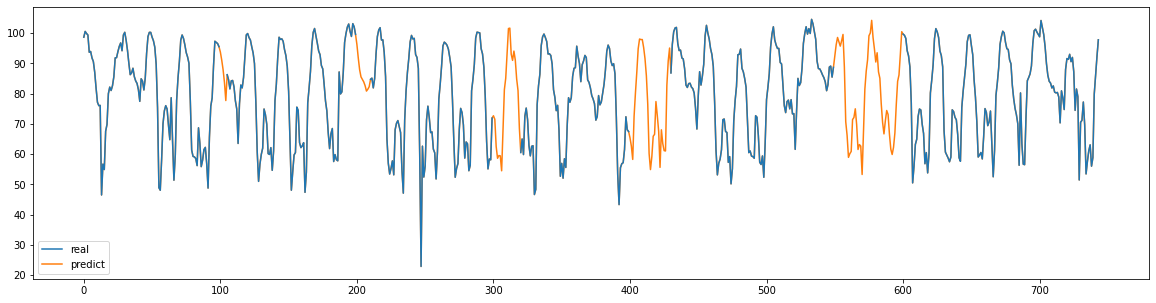

In [11]:
plt.figure(figsize=(20,5))
# plt.plot(real["평균속도"], label="real", zorder=10)
plt.plot(data_ori, label="real", zorder=10)
plt.plot(result, label="predict")
plt.legend()
plt.show()

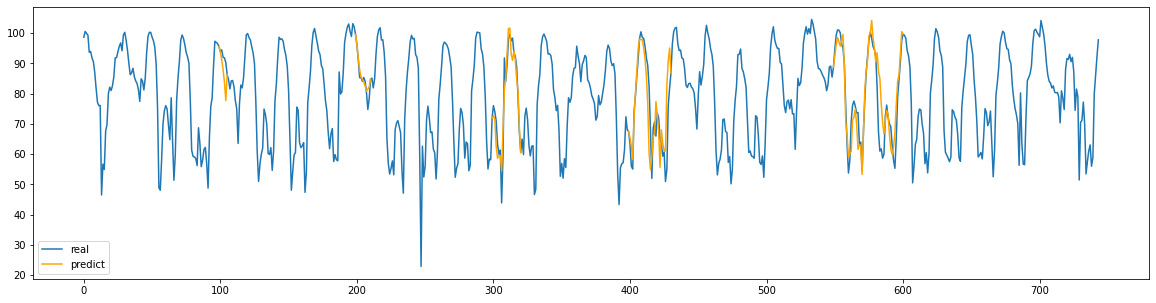

In [12]:
real = pd.read_csv("서인천IC-부평IC 평균속도.csv",encoding='CP949')
plt.figure(figsize=(20,5))
plt.plot(real["평균속도"], label="real")
lb = "predict"
for start, end in missing_range:
    plt.plot(range(start-1,end+1), result[start-1:end+1], label=lb, color="orange")
    lb=None
plt.legend()
plt.show()

In [13]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

realval = real["평균속도"].values
for start,end in missing_range:
    print("길이{}인 구간의 MAPE:{:.3f}".format(end-start, MAPEval(result[start:end,0], realval[start:end])))
    # print(result[start:end,0],realval[start:end] )

길이5인 구간의 MAPE:6.162
길이10인 구간의 MAPE:2.279
길이20인 구간의 MAPE:5.767
길이30인 구간의 MAPE:9.675
길이50인 구간의 MAPE:6.924


# GAN 적용

In [14]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        
        self.hidden_dim = params['discrim_rnn_dim']
        self.action_dim = params['y_dim']
        self.state_dim = params['y_dim']
        self.gpu = params['cuda']
        self.num_layers = params['discrim_num_layers'] 

        self.gru = nn.GRU(self.state_dim, self.hidden_dim, self.num_layers)
        self.dense1 = nn.Linear(self.hidden_dim + self.action_dim, self.hidden_dim)
        self.dense2 = nn.Linear(self.hidden_dim, 1)
            
    def forward(self, x, a, h=None):  # x: seq * batch * 10, a: seq * batch * 10
        p, hidden = self.gru(x, h)   # p: seq * batch * 10
        p = torch.cat([p, a], 2)   # p: seq * batch * 20
        prob = torch.sigmoid(self.dense2(torch.nn.functional.relu(self.dense1(p))))    # prob: seq * batch * 1
        return prob

    def init_hidden(self, batch):
        return Variable(torch.zeros(self.num_layers, batch, self.hidden_dim))

In [15]:
def ones(*shape):
    return torch.ones(*shape).cuda() if use_gpu else torch.ones(*shape)

def zeros(*shape):
    return torch.zeros(*shape).cuda() if use_gpu else torch.zeros(*shape)
    
def update_discrim(discrim_net, optimizer_discrim, discrim_criterion, exp_states, exp_actions, \
                   states, actions, i_iter, dis_times, use_gpu, train = True):
    if use_gpu:
        exp_states, exp_actions, states, actions = exp_states.cuda(), exp_actions.cuda(), states.cuda(), actions.cuda()

    """update discriminator"""
    g_o_ave = 0.0
    e_o_ave = 0.0
    for _ in range(int(dis_times)):
        g_o = discrim_net(Variable(states), Variable(actions))
        e_o = discrim_net(Variable(exp_states), Variable(exp_actions))
        
        g_o_ave += g_o.cpu().data.mean()
        e_o_ave += e_o.cpu().data.mean()
        
        if train:
            optimizer_discrim.zero_grad()
            discrim_loss = discrim_criterion(g_o, Variable(zeros((g_o.shape[0], g_o.shape[1], 1)))) + \
                discrim_criterion(e_o, Variable(ones((e_o.shape[0], e_o.shape[1], 1))))
            discrim_loss.backward()
            optimizer_discrim.step()
    
    if dis_times > 0:
        return g_o_ave / dis_times, e_o_ave / dis_times

# train policy network
def update_policy(policy_net, optimizer_policy, discrim_net, discrim_criterion, \
                  states_var, actions_var, i_iter, use_gpu):
    optimizer_policy.zero_grad()
    g_o = discrim_net(states_var, actions_var)
    policy_loss = discrim_criterion(g_o, Variable(ones((g_o.shape[0], g_o.shape[1], 1))))
    policy_loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 10)
    optimizer_policy.step()

# sample trajectories used in GAN training
def collect_samples_interpolate(policy_net, expert_data, use_gpu, i_iter, task, size=64, name="sampling_inter", draw=False, stats=False, num_missing=None):
    exp_ind = torch.from_numpy(np.random.choice(expert_data.shape[0], size)).long()
    data = expert_data[exp_ind].clone()
    seq_len = data.shape[1]
    #print(data.shape, seq_len)
    if use_gpu:
        data = data.cuda()
    data = Variable(data.transpose(0, 1))
    ground_truth = data.clone()
    
    if num_missing is None:
        num_missing = np.random.randint(seq_len * 4 // 5, seq_len)
        #num_missing = np.random.randint(seq_len * 18 // 20, seq_len)
        #num_missing = 40
    missing_list = torch.from_numpy(np.random.choice(np.arange(1, seq_len), num_missing, replace=False)).long()
    sorted_missing_list, _ = torch.sort(missing_list)
    # print("collect sample:", sorted_missing_list)
    data[missing_list] = 0.0
    has_value = Variable(torch.ones(seq_len, size, 1))
    if use_gpu:
        has_value = has_value.cuda()
    has_value[missing_list] = 0.0
    data = torch.cat([has_value, data], 2)
    data_list = []
    for i in range(seq_len):
        data_list.append(data[i:i+1])
    samples = policy_net.sample(data_list)
    
    states = samples[:-1, :, :]
    actions = samples[1:, :, :]
    exp_states = ground_truth[:-1, :, :]
    exp_actions = ground_truth[1:, :, :]

    # mod_stats = draw_and_stats(samples.data, name + '_' + str(num_missing), i_iter, task, draw=draw, compute_stats=stats, missing_list=missing_list)
    # exp_stats = draw_and_stats(ground_truth.data, name + '_expert' + '_' + str(num_missing), i_iter, task, draw=draw, compute_stats=stats, missing_list=missing_list)
    mod_stats = 0
    exp_stats = 0
    return exp_states.data, exp_actions.data, ground_truth.data, states, actions, samples.data, mod_stats, exp_stats

In [16]:
discrim_net = Discriminator(params).to(device)

In [17]:
policy_learning_rate = 3e-6
discrim_learning_rate = 1e-3
# optimizer
optimizer_policy = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=policy_learning_rate)
optimizer_discrim = torch.optim.Adam(discrim_net.parameters(), lr=discrim_learning_rate)
discrim_criterion = nn.BCELoss()
if use_gpu:
    discrim_criterion = discrim_criterion.cuda()

# stats
exp_p = []
win_exp_p = None
mod_p = []
win_mod_p = None
win_path_length = None
win_out_of_bound = None
win_step_change = None

In [18]:
pretrain_disc_iter = 2000 

# Pretrain Discriminator
progress = trange(pretrain_disc_iter)
for i in progress:
    exp_states, exp_actions, exp_seq, model_states_var, model_actions_var, model_seq, mod_stats, exp_stats = \
        collect_samples_interpolate(model, train_data, use_gpu, i, "task", size = batch_size, name="pretraining", draw=False, stats=False)
    model_states = model_states_var.data
    model_actions = model_actions_var.data
    pre_mod_p, pre_exp_p = update_discrim(discrim_net, optimizer_discrim, discrim_criterion, exp_states, \
        exp_actions, model_states, model_actions, i, dis_times=3.0, use_gpu=use_gpu, train=True)
    progress.set_postfix_str(s="exp:{:.4f} | mod:{:.4f}".format(pre_exp_p.item(), pre_mod_p.item()))
    
    if pre_mod_p < 0.3:
        break

 75%|███████▍  | 1495/2000 [02:45<00:55,  9.02it/s, exp:0.3632 | mod:0.2635]


In [19]:
# GAN training
log_interval = 5
max_iter_num = 1000
progress = trange(max_iter_num)
for i_iter in progress:
    exp_states, exp_actions, exp_seq, model_states_var, model_actions_var, model_seq, mod_stats, exp_stats = \
        collect_samples_interpolate(model, train_data, use_gpu, i_iter, "task", size = batch_size, draw=False, stats=False)
    model_states = model_states_var.data
    model_actions = model_actions_var.data
    
    # update discriminator
    mod_p_epoch, exp_p_epoch = update_discrim(discrim_net, optimizer_discrim, discrim_criterion, exp_states, exp_actions, model_states, model_actions, i_iter, dis_times=3.0, use_gpu=use_gpu, train=True)
    exp_p.append(exp_p_epoch)
    mod_p.append(mod_p_epoch)
    
    # update policy network
    if i_iter > 3 and mod_p[-1] < 0.8:
        update_policy(model, optimizer_policy, discrim_net, discrim_criterion, model_states_var, model_actions_var, i_iter, use_gpu)

    if i_iter % log_interval == 0:
        progress.set_postfix_str(s='{}\texp_p {:.3f}\tmod_p {:.3f}'.format(
            i_iter, exp_p[-1], mod_p[-1]))

100%|██████████| 1000/1000 [03:11<00:00,  5.23it/s, 995	exp_p 0.621	mod_p 0.621]


In [20]:
result = predict_result()

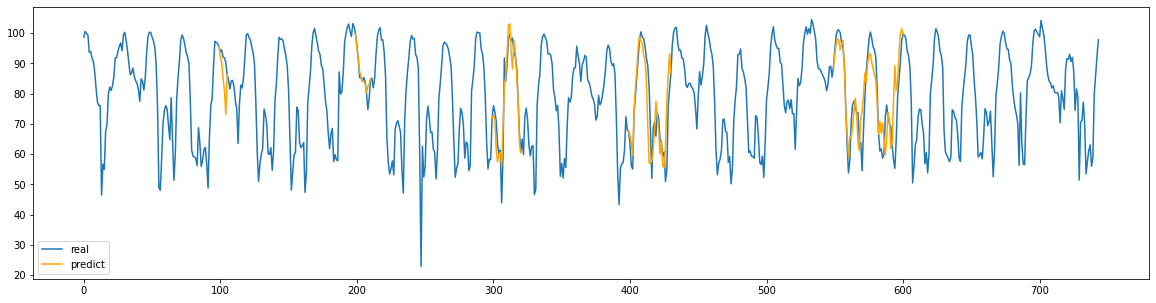

In [21]:
real = pd.read_csv("서인천IC-부평IC 평균속도.csv",encoding='CP949')
plt.figure(figsize=(20,5))
plt.plot(real["평균속도"], label="real")
lb = "predict"
for start, end in missing_range:
    plt.plot(range(start-1,end+1), result[start-1:end+1], label=lb, color="orange")
    lb=None
plt.legend()
plt.show()

In [22]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

realval = real["평균속도"].values
for start,end in missing_range:
    print("길이{}인 구간의 MAPE:{:.3f}".format(end-start, MAPEval(result[start:end,0], realval[start:end])))

길이5인 구간의 MAPE:8.998
길이10인 구간의 MAPE:2.350
길이20인 구간의 MAPE:6.425
길이30인 구간의 MAPE:9.849
길이50인 구간의 MAPE:9.577


GAN적용 후 더 안좋아 졌다.  
시간이 오래걸려서 여러 파라미터로 실험을 해보지는 않았다.